In [1]:
'''Import packages'''

import music21
import musical_scales
from musical_scales import scale
import pqca
import qiskit


In [5]:
'''In the following code, the idea is that we can set the PQCA to always return 12 bits
bit 0 denotes if the chord will be a rest o will be actually played
bit 1 denotes the length of the chord playing
bits 2 and 3 will denote the mode (major/minor)
bits 4 to 11 will denote which notes will be played from the scale as a chord'''

score = [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]

def bit_breakdown(twelve_bits_long):
    return {"rest": twelve_bits_long[0],
            "long": twelve_bits_long[1],
            "scale": twelve_bits_long[2:4],
            "notes": twelve_bits_long[4:12]
    }

bit_breakdown(score)

'''We choose a chord progression.
In this case, I chose the Doo-Wop chord progression, widely diffuse in pop '50s music (I-vi-IV-V) and very uplifting
in C major key (C-Am-F-G)'''

possible_modes = [("C", "major"), ("A", "harmonic minor"), ("F", "major"), ("G", "major")]

def bits_to_scale(mode_bits, modes = possible_modes):
    def note_mode_pair_to_object(note_mode_pair):
        note, mode = note_mode_pair
        return{"fundamental": note, "mode": mode}
    
    if mode_bits[0]:
        if mode_bits[1]:
            return note_mode_pair_to_object(modes[0])
        return note_mode_pair_to_object(modes[1])
    if mode_bits[1]:
        return note_mode_pair_to_object(modes[2])
    return note_mode_pair_to_object(modes[3])

'''Following the above descripted ruleset, this function converts a 12-bit binary number into a chord object.'''

def chord_from_bits(bits, note_lengths=["half","quarter"]):
    breakdown = bit_breakdown(bits)
    duration = note_lengths[0] if breakdown["long"] else note_lengths[1]
    if breakdown["rest"]:
        this_chord = music21.note.Rest(duration=music21.duration.Duration(duration))
    else:
        scale_data = bits_to_scale(breakdown["scale"])
        scale_notes = scale(scale_data["fundamental"], scale_data["mode"])
        list_of_notes = [str(note) for index, note in enumerate(scale_notes)
               if breakdown["notes"][index]]
        this_chord = music21.chord.Chord(list_of_notes)
        this_chord.duration.type = duration
    return this_chord

chord_from_bits(score)


<music21.note.Rest half>

<music21.chord.Chord A3 B3 D4 E4>


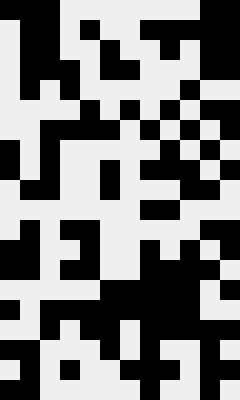

In [6]:
'''Not Quantum Example'''
import drawsvg as draw
'''Random Generated chord sequences'''
import random
class Bit_Generator:
    def __next__(self):
        return[random.random() > 0.5 for i in range(0, 12)]

BG = Bit_Generator()

for i in range(0, 20):
    chord_sequence = chord_from_bits(next(BG))

print(chord_sequence)

instrumentation = music21.instrument.AcousticGuitar() 

def stream_from_chords(chords, instrument=instrumentation):
    stream = music21.stream.Stream()
    stream.insert(0, instrument)
    for chord in chords:
        stream.append(chord)
    return stream

def save_midi(stream, output_midi_file="temp.midi"):
    stream.write("midi",output_midi_file)
    '''stream.show()'''

save_midi(stream_from_chords(chord_sequence))

def quilt(bit_generator, number_of_iterations):
    square_size = 20 # 
    number_of_bits = 12
    drawing = draw.Drawing(square_size*number_of_bits, square_size*number_of_iterations)
    for iteration in range(number_of_iterations):
        state = next(bit_generator)
        for index, bit in enumerate(state):
            colour = '#eeeeee' if bit else '#000000'
            rect = draw.Rectangle(index*square_size,(number_of_iterations-iteration-1)*square_size,square_size,square_size, fill=colour)
            drawing.append(rect)
    return drawing

quilt(BG, 20)



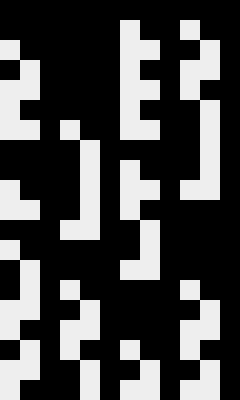

In [14]:
'''Quantum Version'''

num_qubits = 12
tessellated_line = pqca.tessellation.one_dimensional(num_qubits,3)
cx_circuit = qiskit.QuantumCircuit(3)
cx_circuit.h(0)
cx_circuit.cx(0,1)
cx_circuit.z(2)
cx_circuit.cx(2,1)
cx_circuit.draw()

initial_state = [0]*num_qubits
initial_state[0] = 1
initial_state

update_frame1 = pqca.UpdateFrame(tessellated_line, qiskit_circuit = cx_circuit)
update_frame2 = pqca.UpdateFrame(tessellated_line.shifted_by(1), qiskit_circuit=cx_circuit)

automaton = pqca.Automaton(initial_state, [update_frame1], pqca.backend.qiskit())
automaton.state

automaton.update_circuit.draw()
next(automaton)
quilt(automaton, 20)

In [10]:
'''Chord music for quantum cell state'''
chord_sequence = [chord_from_bits(next(automaton)) for i in range(0,20)]
print(chord_sequence)
    
save_midi(stream_from_chords(chord_sequence), "pqca.midi")

[<music21.chord.Chord G3 F#4>, <music21.chord.Chord G3 E4>, <music21.chord.Chord D4 E4>, <music21.note.Rest quarter>, <music21.chord.Chord G3>, <music21.note.Rest half>, <music21.note.Rest quarter>, <music21.note.Rest half>, <music21.note.Rest quarter>, <music21.note.Rest half>, <music21.chord.Chord G3 B3 F#4>, <music21.chord.Chord G3 B3 C4 E4>, <music21.note.Rest quarter>, <music21.note.Rest half>, <music21.chord.Chord G3 C4>, <music21.note.Rest quarter>, <music21.note.Rest half>, <music21.note.Rest quarter>, <music21.chord.Chord object at 0x1e91396b490>, <music21.chord.Chord F3 D4 E4>]
